## Work
1. 試比較有 BN 在 Batch_size = 2, 16, 32, 128, 256 下的差異
2. 請嘗試將 BN 放在 Activation 之前，並比較訓練結果

In [1]:
import os
from tensorflow import keras
import itertools
import warnings
warnings.filterwarnings('ignore')

# Disable GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization, Activation

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], pre_activate=False):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   name="hidden_layer"+str(i+1))(input_layer)
            if pre_activate:
                x = BatchNormalization()(x)
                x = Activation("relu")(x)
            else:
                x = Activation("relu")(x)
                x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   name="hidden_layer"+str(i+1))(x)
            if pre_activate:
                x = BatchNormalization()(x)
                x = Activation("relu")(x)
            else:
                x = Activation("relu")(x)
                x = BatchNormalization()(x)
                
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
# 設定超參數
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = [16, 32, 128, 256]
PRE_ACTIVATE = [True, False]
MOMENTUM = 0.95

In [7]:
results = {}

import itertools
for preact, bz in itertools.product(PRE_ACTIVATE, BATCH_SIZE):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Pre Activation: %s, Batch_size: %i" % (preact, bz))
    model = build_mlp(input_shape=x_train.shape[1:], pre_activate=preact)
    model.summary()
    optimizer = keras.optimizers.Adam(lr=LEARNING_RATE)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=bz, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "Pre Activation: %s, Batch_size: %s" % (preact, str(bz))
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Pre Activation: True, Batch_size: 16
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
activation (Activation)      (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
activation_1 (Activation

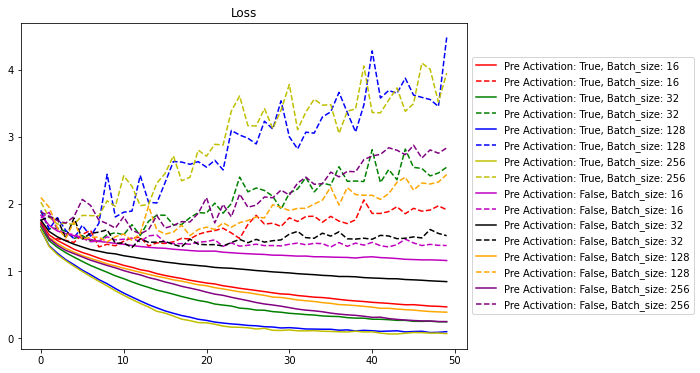

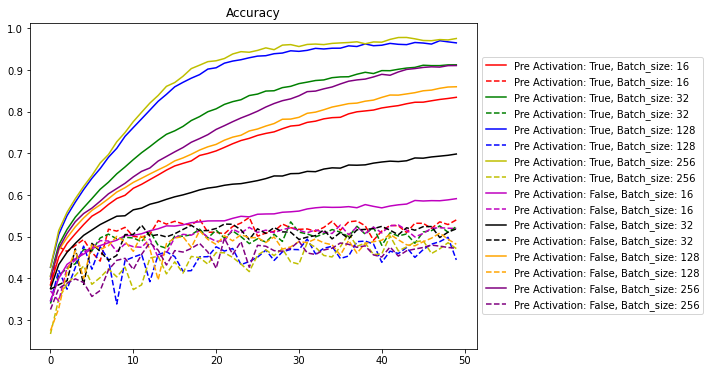

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k", "orange", "purple"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## 筆記
* Batch normalization：除了在 Inputs 做正規化以外，批次正規層讓我們能夠將每一層的輸入/輸出做正規化
* 各層的正規化使得 Gradient 消失 (gradient vanish) 或爆炸 (explode) 的狀況得以減輕 (但最近有 paper 對於這項論點有些不同意)

### batch size越大val loss起伏越大，代表有可能有overfitting